In [1]:
import itertools
import importlib
from functools import reduce, partial
import operator

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from silence_tensorflow import silence_tensorflow
# tf.keras.backend.set_floatx('bfloat32')

In [2]:
# import warnings
# import traceback

# warnings.simplefilter("error")
# warnings.simplefilter("once", category=qml.PennyLaneDeprecationWarning)

In [3]:
from src.layers import *

In [4]:
SEED = 42
np.random.seed(SEED)
# torch.manual_seed(42)
tf.random.set_seed(SEED)

# Data Generation

In [5]:
def generate_dataset_4(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = np.eye(4)[labels]
    return np.array(images), np.array(labels)

def generate_dataset_2(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical or horizontal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.5:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(-1.0)  # Label for vertical line
        else:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1.0)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    # labels = np.array(labels)
    # labels = np.eye(2)[labels]
    return np.array(images), np.array(labels).astype(np.float32)

In [6]:
images, labels = generate_dataset_2(150, noise=0.3)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# conver them to tensors


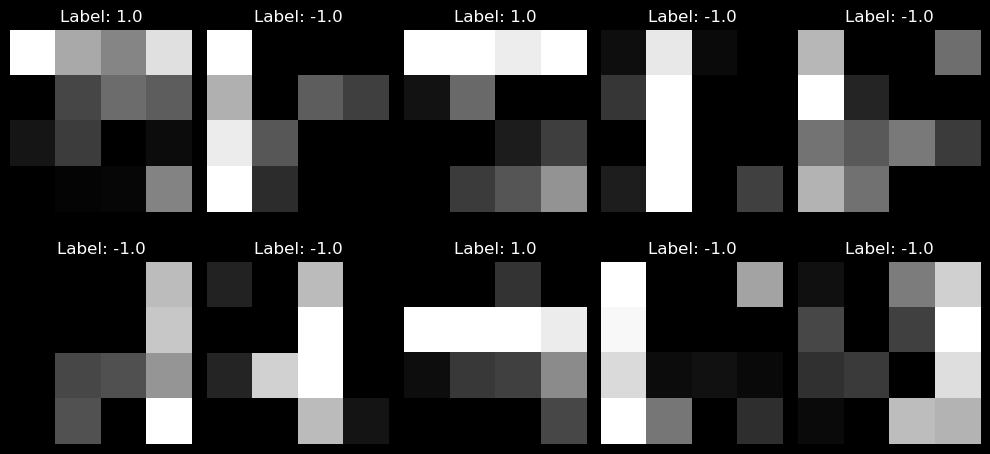

In [7]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(train_images.shape[1], train_images.shape[2]), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
train_images, train_labels = tf.convert_to_tensor(train_images), tf.convert_to_tensor(train_labels)
test_images, test_labels = tf.convert_to_tensor(test_images), tf.convert_to_tensor(test_labels)

2025-05-17 12:01:37.366844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-17 12:01:37.366876: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-17 12:01:37.366884: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1747497697.366896 1200840 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747497697.366916 1200840 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Creating Circuit

In [9]:
assert train_images.shape[1] == train_images.shape[2], "Images must be square"
N = train_images.shape[1]
B = 4
dev = qml.device("default.qubit", wires=N * N + B)
wire_arr = nnp.arange(N * N).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2 # two was working pretty well
STRIDE = 1

In [10]:
# @partial(qml.batch_input, argnums=0) # this is really broken (need to file a pennylane issue)
@qml.qnode(dev)
def qnode(inputs, 
          first_kernel, first_pooling, 
          second_kernel, second_pooling, 
          # fc_weights, fc_bias
):
    # Input Layer
    for i, j in itertools.product(range(N), range(N)):
        qml.RX(1.0 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    # fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]
    # return [qml.probs(i) for i in reduced_wire_arr.flatten().tolist()]

In [11]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "fc_weights": (B - 1, B),
    # "fc_bias": (B,),
}

qlayer = PatchedKerasLayer(qnode, weight_shapes, output_dim=(1,))
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

/Users/addisonhanrattie/Downloads/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


({'first_kernel': (8, TensorShape([2, 2, 2])),
  'first_pooling': (4, TensorShape([2, 2])),
  'second_kernel': (8, TensorShape([2, 2, 2])),
  'second_pooling': (4, TensorShape([2, 2]))},
 <Quantum Keras Layer: func=qnode>)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    qlayer,
    # tf.keras.layers.Lambda(prob_extraction),
])
# model.load_weights('line_model.keras')

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(opt, loss="MSE", metrics=[custom_accuracy])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patched_keras_layer             │ (None, 1)              │            24 │
│ (PatchedKerasLayer)             │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[:3])  # Pass the first 3 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[:5])

Sample output shape: (1, 3)
Sample output: [[-0.00013724  0.00907001 -0.00181562]] tf.Tensor([ 1. -1.  1. -1. -1.], shape=(5,), dtype=float32)


# Model Training

In [39]:
silence_tensorflow("ERROR")
fitting = model.fit(train_images, train_labels, epochs=1, batch_size=3, validation_data=(test_images, test_labels), verbose=1, shuffle=True)

35/35 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - custom_accuracy: 0.8120 - loss: 0.9470 - val_custom_accuracy: 0.6667 - val_loss: 0.9327


In [ ]:
model.get_weights()[0]

In [ ]:
model.save("models/line_model.keras")

# A Classical Model

In [38]:
classic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.MaxPooling2D(pool_size=KERNEL_SIZE),
    tf.keras.layers.Conv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.MaxPooling2D(pool_size=KERNEL_SIZE),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Softmax(),
])
classic_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 1)        │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 2, 2, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 2, 2, 1)        │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10 (40.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
classic_labels = tf.where(train_labels > 0.5, 1.0, 0.0)
model.compile(opt, loss="CrossEntropy", metrics=["accuracy"])